#  DSC540-T302 Data Preparation  #

## Project Milestone 4 ##

### Saravanan Janarthanan ###

-------------

In [1]:
import sqlite3
import pandas as pd
import numpy as np


**Project Requirement**

- Load each dataset into SQL Lite as an individual table and then you must join the datasets together in Python into 1 dataset.

- Once all the data is merged together in your database, create 5 visualizations that demonstrate the data you have cleansed.

**Read, Load and transform data for all the three formats**
- Read  **Flat File** ,  clean or transform and load into a sqllite table
- Read  website contents by **webscraping** it, parse or find the content ,  clean it up  or transform and load into a sqllite table
- Use the **API** call to recieve webservice response ,  clean if needed ,  transform and load into a sqllite table
- Read the data in these 3 tables by joining them using SQL query and load them in a dataframe
- Use the merged data in Dataframe and choose column / features to build visulaization


-----------
-----------

### 1. FLAT File ####

-----
-----

**Read  Flat File,  clean or transform and load into a sqllite table**

#### 1.1 Read and Load Flat file into Database ####

In [2]:
#  Load the data file in a dataframe
sp500_df = pd.read_csv('SNP_500_Performance_data.csv')
sp500_df.head()

,Symbol,Name,Market Cap,P/E,EPS,Net Income,Beta,Dividend,Div Yield,Extended Hr Last Price,...,52W Low,52W High,Wtd Alpha,YTD %Chg,1M %Chg,3M %Chg,52W %Chg,Sector,ISIN,Volume
0,A,Agilent Technologies,4.223508e+10,26.32,5.37,1240000000,1.11,0.922,0.64%,144.12,...,96.80,151.58,12.11,3.66%,-0.16%,10.39%,4.37%,Health Technology,US00846U1016,1.656?M
1,AAL,American Airlines Gp,9.009457e+09,5.24,2.64,822000000,1.57,NaN,0.00%,13.75,...,10.86,19.08,2.39,0.15%,-6.20%,1.18%,-0.94%,Transportation,US02376R1023,30.632?M
2,AAPL,Apple Inc,2.620000e+12,26.30,6.42,96995000000,1.27,0.960,0.57%,169.47,...,159.78,199.62,-3.00,-11.92%,-0.32%,-6.40%,3.55%,Electronic Technology,US0378331005,42.104?M
3,ABBV,Abbvie Inc,3.010000e+11,15.11,11.11,4863000000,0.58,5.990,3.52%,169.99,...,130.96,182.89,10.74,9.70%,-5.11%,4.85%,5.72%,Health Technology,US00287Y1091,7.03?M
4,ABNB,Airbnb Inc Cl A,1.050000e+11,36.85,4.31,4792000000,1.25,NaN,0.00%,161.77,...,103.55,170.10,43.69,18.83%,1.53%,18.97%,40.25%,Consumer Services,US0090661010,2.226?M


**1.2 Change header of file dataset**

- View the header names
- identfy the ones that needs to be changed
- Retrieve the current headers in a list
- Perform the changes to the identified headers in the list
- Set the new headers using the modfiied list values

In [3]:
header_nms = sp500_df.columns.tolist()
# Change 4th column (index 3) header from "P/E" to "Price Earnings"
# Change 12th column (index 11) header from "%Chg (Ext)" to "Extended Hr %Change" 
# Change 18th column (index 17) header from "20D Rel Str" to "20D Relative Strength"

header_nms[3] = "Price Earnings Ratio"
header_nms[11] = "Extended Hr %Change"
header_nms[17] = "20D Relative Strength"

sp500_df.columns = header_nms



**1.3 Convert float number to int64 to remove expontential listing or displaying**

- Column 'Market Cap'  displays in exponential form that impacts readability.
- Convert that column values to integer 64 base to display the whole numbers

In [4]:
sp500_df["Market Cap"] =  sp500_df["Market Cap"].astype('int64')

**1.4 Replace  special character,  replace  with  a no character or null character**

- Column 'Volume' has '?' character in betweeen the values
- Use the String replace method to replace the '?' character with ''

In [5]:
sp500_df['Volume'] = sp500_df['Volume'].str.replace('?', '')

**1.5 Persist the Flat file data's  dataframe in Database**

In [6]:
# Fill blanks with '_' in all header names for easy querying
sp500_df.columns = sp500_df.columns.str.replace(' ', '_')

# connect to a database,  creates one if not in memory or connects to a new one
conn = sqlite3.connect('SJ_Project.db')
try:
    # Save the DataFrame to  database
    sp500_df.to_sql('FlatFile', conn, if_exists='replace', index=False)
    print("DataFrame written to SQLite successfully.")
# Catch any exception and prijt error message
except Exception as e:
    print(f"An error occurred: {e}")
    


# Verify the loaded Flatfile data by reading from table
try:
    df_read = pd.read_sql('SELECT Symbol, Name, Market_Cap FROM FlatFile limit 10', conn)
    print(df_read)
except Exception as e:
    print(f"An error occurred while reading from table FlatFile: {e}")
    
# Close the connection
conn.close()

DataFrame written to SQLite successfully.
  Symbol                  Name     Market_Cap
0      A  Agilent Technologies    42235084000
1    AAL  American Airlines Gp     9009457000
2   AAPL             Apple Inc  2620000000000
3   ABBV            Abbvie Inc   301000000000
4   ABNB       Airbnb Inc Cl A   105000000000
5    ABT   Abbott Laboratories   193000000000
6   ACGL  Arch Capital Grp Ltd    35601260000
7    ACN         Accenture Plc   223000000000
8   ADBE     Adobe Systems Inc   217000000000
9    ADI        Analog Devices    96583040000


--------------
--------------


### 2. Web Scrape Data ####


-----
-----


**Read  website contents by webscraping it, parse or find the content ,  clean it up  or transform and load into a sqllite table**

#### 2.1 Read and Load web scraped data into Database ####

In [7]:
# Load the BeautifulSoup 
from bs4 import BeautifulSoup
import requests

In [8]:
# Url to load the web scrape data
web_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks'

# Fetch the HTML content of the webpage
response = requests.get(web_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

# scrape the html data    
tables = soup.find_all('table')
wiki_tables = soup.find("table", {"class": "wikitable sortable"})
th_elements = wiki_tables.find_all('th')
tables_hdr = [cell.text.strip() for cell in th_elements]

In [9]:
# Reteieve all the TR tags 
rows = wiki_tables.find_all('tr')

# Declare a list to hold all the row data of the table
temp_lst = []

for row in rows:
    # filter all the TD,  tags 
    cells = row.find_all(['td'])
        
    # strip other values and retrieve only the tag text values
    row_data = [cell.text.strip() for cell in cells]
    temp_lst.append(row_data)

In [10]:
# Load the parsed data in a dataframe
web_df = pd.DataFrame(temp_lst,  columns=tables_hdr)
web_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,None,None,None,None,None,None,None,None
1,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902
2,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
3,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888
4,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)


**2.2 Replace the Web scrped data frame column headers**
- Replace 'Security'  with 'Company Name'
- Replace 'CIK'  with 'Central Index Key'
- Replace 'Founded'  with 'Year Founded'

In [11]:
# Define new column header
tables_hdr[0] = 'WS_Symbol'
tables_hdr[1] = 'Company Name'
tables_hdr[6] = 'Central Index Key'
tables_hdr[7] = 'Year Founded'

In [12]:
# Fill blanks with '_' in all header names for easy querying
tables_hdr = [x.replace(' ', '_')  for x in tables_hdr]

In [13]:
# update the column headers
web_df.columns = tables_hdr

#### 2.3 Remove bad Data in Web scraped dataframe ####
Remove rows that has no value
-  Remove the first row that has no value  ' None'

In [14]:
# Drop row at index position 0 
web_df = web_df.drop(web_df.index[0])

#### 2.4 Format Data in Web scraped dataframe ####
Year founded column has year value. some of the rows has other info appended
-  Trim those value appended after year value.  Year is 4 char in length,  hence slice the characters after 4 characters

In [15]:
web_df['Year_Founded'] = web_df['Year_Founded'].str[:4]

**2.5 Persist the web scraped data's dataframe in Database**

In [16]:
# connect to a database,  creates one if not in memory or connects to a new one
conn = sqlite3.connect('SJ_Project.db')
try:
    # Save the DataFrame to  database
    web_df.to_sql('WebScrapedData', conn, if_exists='replace', index=False)
    print("DataFrame written to SQLite successfully.")
# Catch any exception and prijt error message
except Exception as e:
    print(f"An error occurred: {e}")
    


# Verify by reading from table
try:
    df_read = pd.read_sql('SELECT WS_Symbol, Company_Name, Year_Founded FROM WebScrapedData limit 10', conn)
    print(df_read)
except Exception as e:
    print(f"An error occurred while reading from table FlatFile: {e}")
    
# Close the connection
conn.close()

DataFrame written to SQLite successfully.
  WS_Symbol            Company_Name Year_Founded
0       MMM                      3M         1902
1       AOS             A. O. Smith         1916
2       ABT                  Abbott         1888
3      ABBV                  AbbVie         2013
4       ACN               Accenture         1989
5      ADBE              Adobe Inc.         1982
6       AMD  Advanced Micro Devices         1969
7       AES         AES Corporation         1981
8       AFL                   Aflac         1955
9         A    Agilent Technologies         1999


-----
-----

### 3. Read API data ####


-----
-----

**Use the API call to recieve webservice response ,  clean if needed ,  transform and load into a sqllite table**

#### 3.1 Read and Load API queried data into Database ####

In [17]:
import json

with open('PolygonKey.json') as f:
    keys = json.load(f)
    Polygon_key = keys['Polygon_key']

In [18]:
# url to access the api,  using 5/15 date data 
poly_url = "https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/2024-05-15"
# define the url load params
url_param = {}
url_param['apikey'] = Polygon_key
url_param['adjusted'] = 'false'

poly_data = ""

# use the response module to get the JSON data
try:
    response = requests.get(url=poly_url, params=url_param)
    json_res_data = response.json()
    # check if the response is good,  status attribute has value'OK', if so load the data of results attribute 
    # that contains stock data
    if json_res_data['status'] == 'OK':
        poly_df = pd.DataFrame(json_res_data['results'])
    else:
        err_msg = "Error Occured while searching title " + title_name
        if 'Error' in list(json_res_data.keys()):
            err_msg = err_msg + " Error Message recieved : "+ json_res_data['Error']
        print(err_msg)
except Exception as e:
    print(f"Error while retrieving title details from OMDB : {e}")
    print(e)

In [19]:
# print the Dataframe
poly_df

,T,v,vw,o,c,h,l,t,n
0,BPTH,136171.0,2.3038,2.400,2.24000,2.680000,2.0800,1715803200000,910.0
1,POLA,201286.0,0.5142,0.507,0.53690,0.537000,0.4800,1715803200000,453.0
2,BNOX,38878.0,0.9249,0.925,0.92005,0.948999,0.8978,1715803200000,133.0
3,IAT,174090.0,43.5808,43.650,43.65000,43.950000,43.3300,1715803200000,2198.0
4,RUM,3120835.0,6.9658,6.940,7.15000,7.250000,6.5600,1715803200000,24225.0
...,...,...,...,...,...,...,...,...,...
10495,ZTST,0.0,NaN,40.170,40.17000,40.170000,40.1700,1715803200000,NaN
10496,ZBZX,0.0,NaN,25.000,25.00000,25.000000,25.0000,1715803200000,NaN
10497,ZVZZT,211707.0,18.7798,20.250,39.85000,39.850000,11.0000,1715803200000,1413.0
10498,ZTEST,0.0,NaN,8662.955,8662.95500,8662.955000,8662.9550,1715803200000,NaN


**3.2 Change the header names in API queried data**
- Change header name 'T' as 'Symbol' in   column 1  (index 0)
- Change 'v' as 'Volume'  in   column 2  (index 1)
- Change 'c' as 'Closing Price' in   column 5  (index 4)
- Change 'h' as 'Highest Price' in   column 6  (index 5)
- Change 'l' as 'Lowest Price' in   column 7  (index 6)
- Change 't' as 'Timestamp' in   column 8  (index 7)
- Change 'vw' as 'Vol Wt Avg Price' in   column 3  (index 2)
- Change 'o' as 'Open Price' in column 4 (index 3)
- Change 'n' as 'Number of Transactions' in column 9 (index 8)

In [20]:
# Retrieve the header names to change them
header_nms = poly_df.columns.tolist()

# Map the new names to the right indexes as intended
header_nms[0] = 'API_Symbol'
header_nms[1] = 'API_Volume'
header_nms[2] = 'Vol Wt Avg Price'
header_nms[3] = 'Open Price'
header_nms[4] = 'Closing Price'
header_nms[5] = 'Highest Price'
header_nms[6] = 'Lowest Price'
header_nms[7] = 'Timestamp'
header_nms[8] = 'Number of Transactions'

In [21]:
# Fill blanks with '_' in all header names for easy querying
header_nms = [x.replace(' ', '_')  for x in header_nms]

In [22]:
# Update the new headernames to dataframe 
poly_df.columns = header_nms
poly_df.head()

,API_Symbol,API_Volume,Vol_Wt_Avg_Price,Open_Price,Closing_Price,Highest_Price,Lowest_Price,Timestamp,Number_of_Transactions
0,BPTH,136171.0,2.3038,2.400,2.24000,2.680000,2.0800,1715803200000,910.0
1,POLA,201286.0,0.5142,0.507,0.53690,0.537000,0.4800,1715803200000,453.0
2,BNOX,38878.0,0.9249,0.925,0.92005,0.948999,0.8978,1715803200000,133.0
3,IAT,174090.0,43.5808,43.650,43.65000,43.950000,43.3300,1715803200000,2198.0
4,RUM,3120835.0,6.9658,6.940,7.15000,7.250000,6.5600,1715803200000,24225.0


**3.3 Convert 'Volume' and "Number of Transactions" to intger values**

In [23]:
import math

# fill the misssing values with 0 to avoid any conversion data format issues
poly_df['Number_of_Transactions'] = poly_df['Number_of_Transactions'].fillna(0)

# use astype to change the data type
poly_df['API_Volume']                    = poly_df['API_Volume'].round().astype(int)
poly_df['Number_of_Transactions']    = poly_df['Number_of_Transactions'].round().astype(int)

**3.4 Fill the average price of misssing values in 'Vol Wt Avg Price' with average price of 'Open price and 'Closing Price'**

- Create a dummy column to fill the avg price for all columns
- Then using fillna method copy the new column values with avg price into na rows of 'Vol Wt Avg Price' column
- Drop the new column

In [24]:
# create  a new temp column to store the average price using mean value
poly_df['new_avg_price'] = poly_df[['Open_Price', 'Closing_Price']].mean(axis=1)
poly_df['new_avg_price'] = poly_df['new_avg_price'].round(2) # round the values to 2 decimals

# Copy the average price in the temp column to the null or NA rows values for 'Vol Wt Avg Price' column
poly_df['Vol_Wt_Avg_Price'] = poly_df['Vol_Wt_Avg_Price'].fillna(poly_df['new_avg_price'])
poly_df = poly_df.drop(columns=['new_avg_price'])

**3.5 Convert 'Timestamp' field with milli second values to a timezone field with date and time**

In [25]:
# Convert timestamp in millis to regulat date, time format in UTC timezone format  and then convert the same from UTC to EST
import pytz
poly_df['Timestamp'] = pd.to_datetime(poly_df['Timestamp'], unit='ms')
poly_df['Timestamp'] = poly_df['Timestamp'].dt.tz_localize('UTC')
poly_df['Timestamp'] = poly_df['Timestamp'].dt.tz_convert('US/Eastern')

**3.6 Persist the web scraped data's dataframe in Database**

In [26]:
# connect to a database,  creates one if not in memory or connects to a new one
conn = sqlite3.connect('SJ_Project.db')
try:
    # Save the DataFrame to  database
    poly_df.to_sql('APIData', conn, if_exists='replace', index=False)
    print("DataFrame written to SQLite successfully.")
# Catch any exception and prijt error message
except Exception as e:
    print(f"An error occurred: {e}")
    


# Verify by reading from table
try:
    df_read = pd.read_sql('SELECT API_Symbol, API_Volume, Timestamp FROM APIData limit 10', conn)
    print(df_read)
except Exception as e:
    print(f"An error occurred while reading from table FlatFile: {e}")
    
# Close the connection
conn.close()

DataFrame written to SQLite successfully.
  API_Symbol  API_Volume                  Timestamp
0       BPTH      136171  2024-05-15 16:00:00-04:00
1       POLA      201286  2024-05-15 16:00:00-04:00
2       BNOX       38878  2024-05-15 16:00:00-04:00
3        IAT      174090  2024-05-15 16:00:00-04:00
4        RUM     3120835  2024-05-15 16:00:00-04:00
5        AJX      116684  2024-05-15 16:00:00-04:00
6       INMD     1058873  2024-05-15 16:00:00-04:00
7       BALT       73089  2024-05-15 16:00:00-04:00
8       ALTI      150409  2024-05-15 16:00:00-04:00
9       CRON     2600970  2024-05-15 16:00:00-04:00


In [27]:
query =    "SELECT * FROM FlatFile \
    LEFT JOIN WebScrapedData ON FlatFile.Symbol = WebScrapedData.WS_Symbol \
    LEFT JOIN APIData ON FlatFile.Symbol = APIData.API_Symbol"

In [28]:
# connect to a database,  creates one if not in memory or connects to a new one
conn = sqlite3.connect('SJ_Project.db')

try:
    df_combined = pd.read_sql(query, conn)
except Exception as e:
    print(f"An error occurred while reading from table FlatFile: {e}")
    
# Close the connection
conn.close()

In [29]:
# Display the merged dataframe data 
df_combined

,Symbol,Name,Market_Cap,Price_Earnings_Ratio,EPS,Net_Income,Beta,Dividend,Div_Yield,Extended_Hr_Last_Price,...,Year_Founded,API_Symbol,API_Volume,Vol_Wt_Avg_Price,Open_Price,Closing_Price,Highest_Price,Lowest_Price,Timestamp,Number_of_Transactions
0,A,Agilent Technologies,42235084000,26.32,5.37,1240000000,1.11,0.922,0.64%,144.1200,...,1999,A,1493858.0,153.7663,153.00,154.08,154.5500,152.5100,2024-05-15 16:00:00-04:00,31116.0
1,AAL,American Airlines Gp,9009457000,5.24,2.64,822000000,1.57,NaN,0.00%,13.7500,...,1934,AAL,25741362.0,15.0357,15.20,14.94,15.2500,14.9101,2024-05-15 16:00:00-04:00,77768.0
2,AAPL,Apple Inc,2620000000000,26.30,6.42,96995000000,1.27,0.960,0.57%,169.4700,...,1977,AAPL,67561123.0,189.6510,187.91,189.72,190.6500,187.3700,2024-05-15 16:00:00-04:00,727552.0
3,ABBV,Abbvie Inc,301000000000,15.11,11.11,4863000000,0.58,5.990,3.52%,169.9900,...,2013,ABBV,5171030.0,163.4039,162.31,163.79,164.4200,161.8700,2024-05-15 16:00:00-04:00,77209.0
4,ABNB,Airbnb Inc Cl A,105000000000,36.85,4.31,4792000000,1.25,NaN,0.00%,161.7700,...,2008,ABNB,5974665.0,145.8275,147.57,145.80,147.6900,144.7500,2024-05-15 16:00:00-04:00,75551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc,31092520000,34.58,3.68,609000000,1.10,1.350,1.05%,128.6500,...,2011,XYL,1369644.0,143.5998,142.93,143.79,144.0300,142.8800,2024-05-15 16:00:00-04:00,29679.0
499,YUM,Yum! Brands,38289832000,26.36,5.17,1597000000,1.10,2.485,1.83%,136.1000,...,1997,YUM,1776217.0,138.4509,137.14,138.34,139.1399,137.1400,2024-05-15 16:00:00-04:00,34102.0
500,ZBH,Zimmer Biomet Holdings,26161348000,16.87,7.56,1024000000,1.01,0.960,0.75%,127.3300,...,1927,ZBH,1072109.0,120.7804,120.58,120.98,121.1900,120.0800,2024-05-15 16:00:00-04:00,25284.0
501,ZBRA,Zebra Technologies,14920015000,33.29,8.80,296000000,1.79,NaN,0.00%,291.8600,...,1969,ZBRA,217112.0,323.6973,323.00,323.87,325.1100,322.2130,2024-05-15 16:00:00-04:00,10073.0


In [30]:
df_combined.isnull().sum()

Symbol                     0
Name                       0
Market_Cap                 0
Price_Earnings_Ratio       0
EPS                        0
Net_Income                 0
Beta                       2
Dividend                  99
Div_Yield                  0
Extended_Hr_Last_Price     0
Extended_Hr_Change_        0
Extended_Hr_%Change        0
Time                       0
Last_Price                 0
Change                     0
%Chg                       0
Opinion                    1
20D_Relative_Strength      0
20D_His_Vol                0
20D_Avg_Vol                0
52W_Low                    0
52W_High                   0
Wtd_Alpha                  0
YTD_%Chg                   0
1M_%Chg                    0
3M_%Chg                    0
52W_%Chg                   2
Sector                     0
ISIN                       0
Volume                     0
WS_Symbol                  3
Company_Name               3
GICS_Sector                3
GICS_Sub-Industry          3
Headquarters_L

### Visulization on combined Data ###

***Visulization 1***

**Column 'Sector' from Flat file dataset to display the pie chart** 
- Group the sector values and count of stick symbols or companies
- Since there are high number of sectors listed,  top 5 records are used for building the pie chart

In [31]:
# Use the sector value counts - Numnber of records against each sector category
sector_data = df_combined.Sector.value_counts()

# assign the value count data into category index and its counts 
sec_idx = sector_data.index
sec_values = sector_data.values

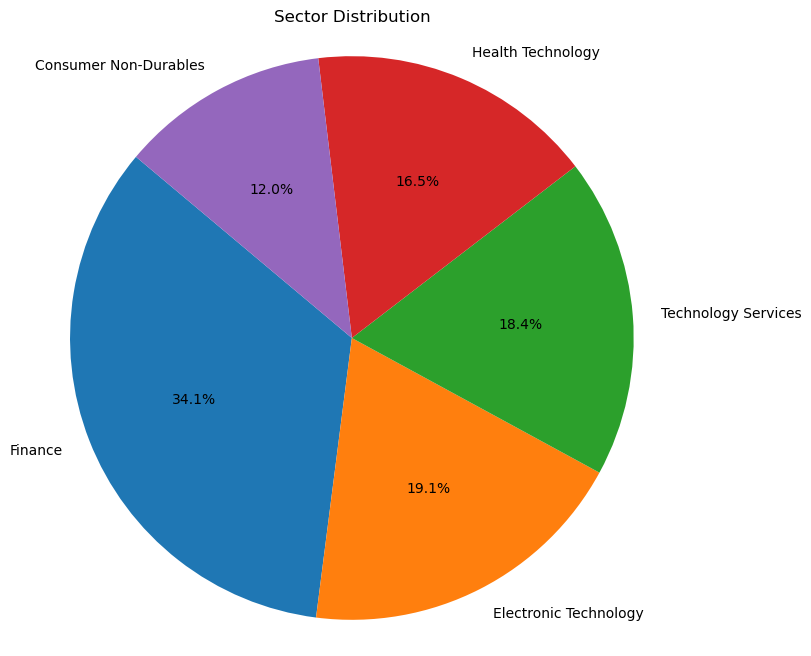

In [32]:
import matplotlib.pyplot as plt

# choose top 5 count records
labels = sec_idx[:5]
sizes = sec_values[:5]

# Create a pie chart
plt.figure(figsize=(8, 8))
# plot the pie with the first cateory pie line ar 140 degrees
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Sector Distribution')

# Show the plot
plt.show()

**Pie Chart shows that Finance sector S&P 500 companies are more in the top 5 sectors**


-----
***Visulization 2***

**Use 'Headquarters Location' from web scraped dataset and 'Net Income' from Flat File dataset to build bar chart to show number of companies**
- Group the headquarters location data and choose the top 5 locations
- Use those 5 locations and aggregate the net income values (summing the values)
- Aggregated values are re-scaled to billions for better chart scales


In [33]:
# Retrieve the head quarters unique values and their counts
HQ_Loc = df_combined['Headquarters_Location'].value_counts()

In [34]:
# choose the top five locations
Top5_HQ = HQ_Loc.index[:5].tolist()

In [35]:
# Step 3: Filter the DataFrame to filter the top 5 locations
filtered_df = df_combined[df_combined['Headquarters_Location'].isin(Top5_HQ)]

In [36]:
# Aggregate the net income for the top 5 locations from new dataframe
aggregated_df = filtered_df.groupby('Headquarters_Location')['Net_Income'].sum().reset_index()

In [37]:
# Convert the net ccom values to billions
aggregated_df['Net_Income'] = aggregated_df['Net_Income'] / 1000000000

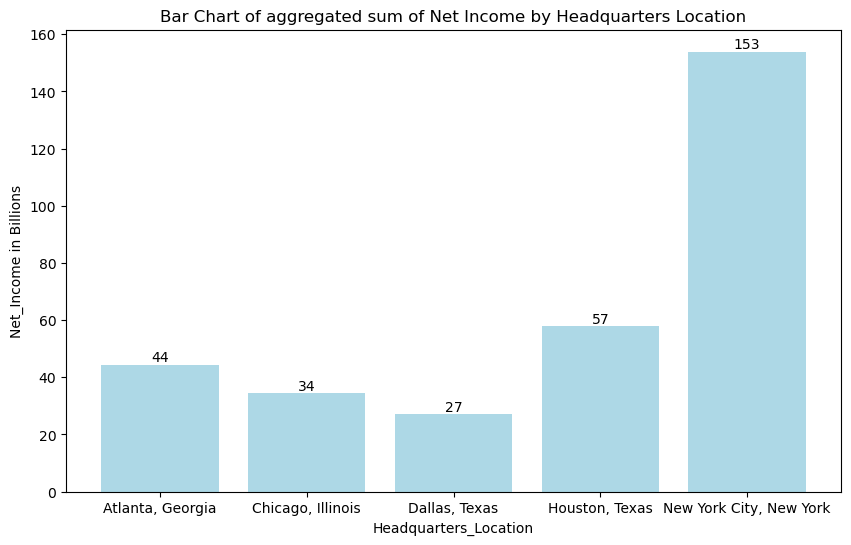

In [38]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(aggregated_df['Headquarters_Location'], aggregated_df['Net_Income'], color='lightblue')

# Add titles and labels
plt.title('Bar Chart of aggregated sum of Net Income by Headquarters Location')
plt.xlabel('Headquarters_Location')
plt.ylabel('Net_Income in Billions')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')


# Show the plot
plt.show()

**Bar chart shows New york as head quarters for max number of S&P500 compnaies**


------
***Visulization 3***

***Using Column 'Year Founded'  from webscraped dataset and bin those as a dcade and then use the count of stock symbols or companies to show the magnitude of compaines founded in the decade**

This visualization shows whihc decade had more S&P 500 compaines were founded
- Use 'Year Founded'  column as a seperate dataframe
- Bin the year founded data into a equal width , 10 years , groups
- find the count of records for each decade and use the same for visualization 

In [39]:
# Create a year founded feature dataframe
df_temp = df_combined['Year_Founded']
# drop null records
df_temp = df_temp.dropna()
# convert to integer value
df_temp = df_temp.astype(int)

In [40]:
# Bin the years to decades
df_decade = (df_temp // 10) * 10

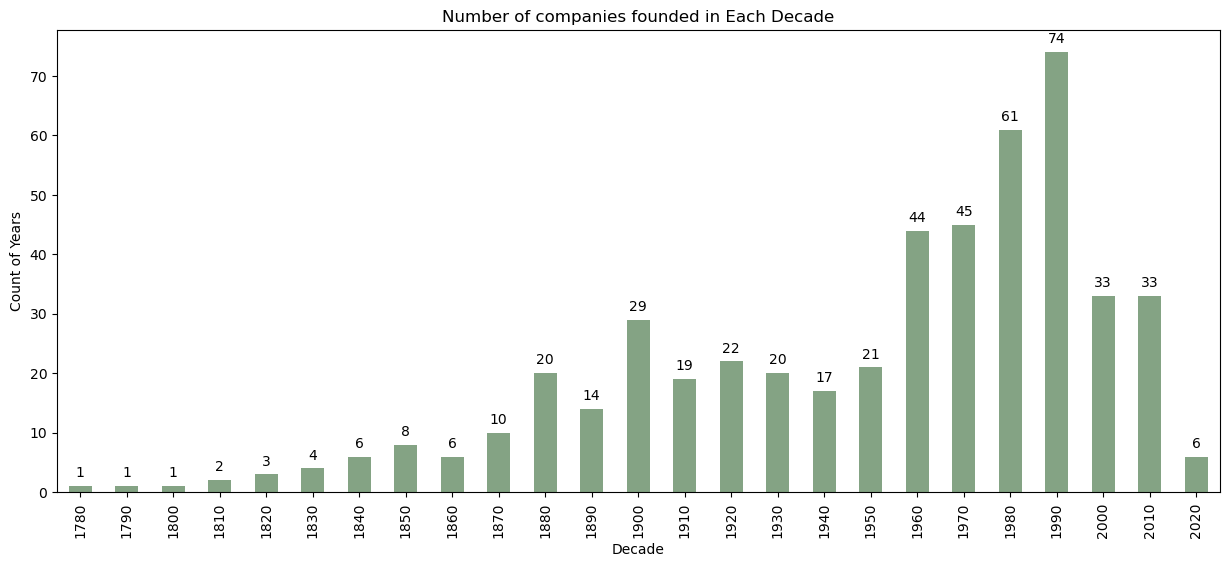

In [41]:
decades_num_of_companies = df_decade.value_counts().sort_index()
# Plot the bar chart
plt.figure(figsize=(15, 6))
color = (0.2, 0.4, 0.2, 0.6 ) 
#bars = plt.bar(decades_num_of_companies.index, decades_num_of_companies.values, color='lightblue')
ax = decades_num_of_companies.plot(kind='bar', color=color)

# Add titles and labels
plt.title('Number of companies founded in Each Decade')
plt.xlabel('Decade')
plt.ylabel('Count of Years')


# Annotate each bar with its value
for i, v in enumerate(decades_num_of_companies):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')
    
# Show the plot
plt.show()

Bart chart shows 1990 decade had max number of S&P 500 companies were founded

-----

***Visulization 4***

**Use 'EPS' and 'P/E ratio' from Flat File and 'GICS Sector' from web scraping dataset to show correlation between EPS and P/E ration and highlight the sector that shows spread**

- The High EPS and high P/E ratio shows a god performance of the stock
- Using the sector highlighting helps to identify the sector growth as well individual stock symbol performce within a sector

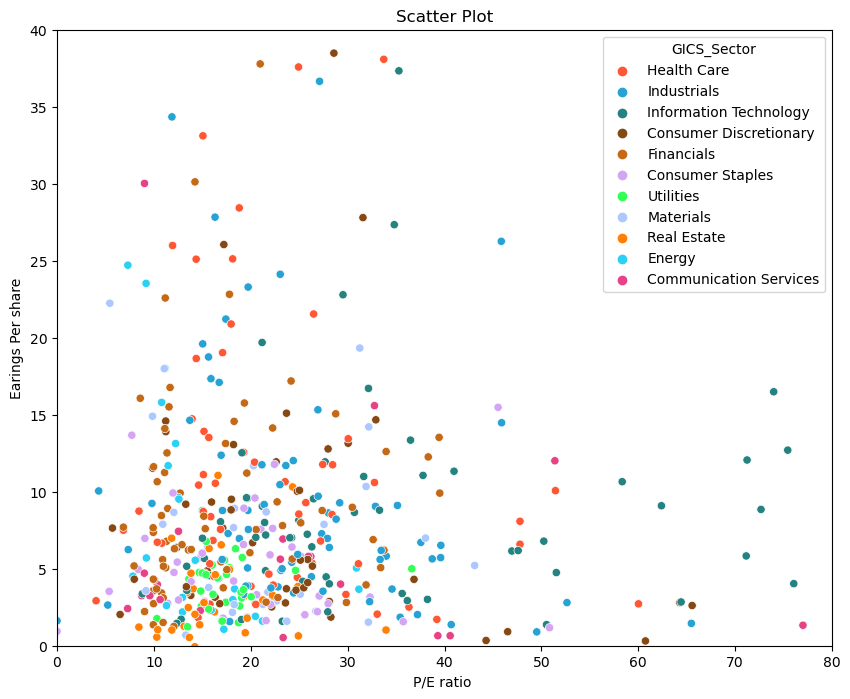

In [42]:
import seaborn as sns

# Use the Price earning ratio  and EPS (Earnings Per share) values to print the scatter plot
x = df_combined['Price_Earnings_Ratio']
y = df_combined['EPS']


# Create a scatter plot
plt.figure(figsize=(10, 8))

#custom_palette = sns.color_palette(["#9b59b6", "#3498db", "#95a5a6", '#ff6347', '#ff4500', '#ff1493', '#FF9633', '#9633FF', '#F6FF33', ])
#custom_palette = sns.color_palette(['#FF5733', '#33FF57',  '#3357FF', '#FF33F6', '#57FF33', '#FF9633', '#33FFF6','#9633FF', '#F6FF33','#FF3333', '#33FF96' ])
custom_palette = sns.color_palette(['#FF5733', '#27a2d4', '#248280', '#874914', '#c46a16', '#d4a5f5', '#33FF57' , '#adc8ff', '#ff8004', '#2bd0f5', '#e54385'])
#sns.scatterplot(data=df_combined, x='Price_Earnings_Ratio', y='EPS', hue='GICS_Sector', palette='viridis')
sns.scatterplot(data=df_combined, x='Price_Earnings_Ratio', y='EPS', hue='GICS_Sector', palette=custom_palette)

plt.title('Scatter Plot')
plt.xlabel('P/E ratio ')
plt.ylabel('Earings Per share')
plt.xlim(0, 80)  
plt.ylim(0, 40)  

# Show the plot
plt.show()

-----
***Visulization 5***

**Use the 'Volume'  from Flat file datset  and 'API_Volume' from API dataset to compare volume values between these three datasets**

Flat file volume has a postfix M for millions and K for 1000s ,  hence convert he same to whole number.

In [43]:
# Define a method to convert values to 1000s or millions based on prefix
def convertValuePostFixToNumber(value):
    retval = float(value[:-1])
    postfix = value[-1:]
    
    if postfix == 'M':
        return retval*1000000
    elif postfix == 'K':
        return retval*1000
    else:
        return 0

    
# Create a new Dataframe to hold both volume features
df_vol = pd.DataFrame()
# Create a new column to load the merged data Flat file volume column
df_vol['Flatfile_Volume'] = df_combined['Volume']
# Create a new column to load the merged API volume column
df_vol['API_volume']      = df_combined['API_Volume']
# Drop any null values
df_vol = df_vol.dropna()
# Convert post values to respective whole numbers
df_vol['Flatfile_Volume'] = [convertValuePostFixToNumber(x) for x in df_vol['Flatfile_Volume']] 

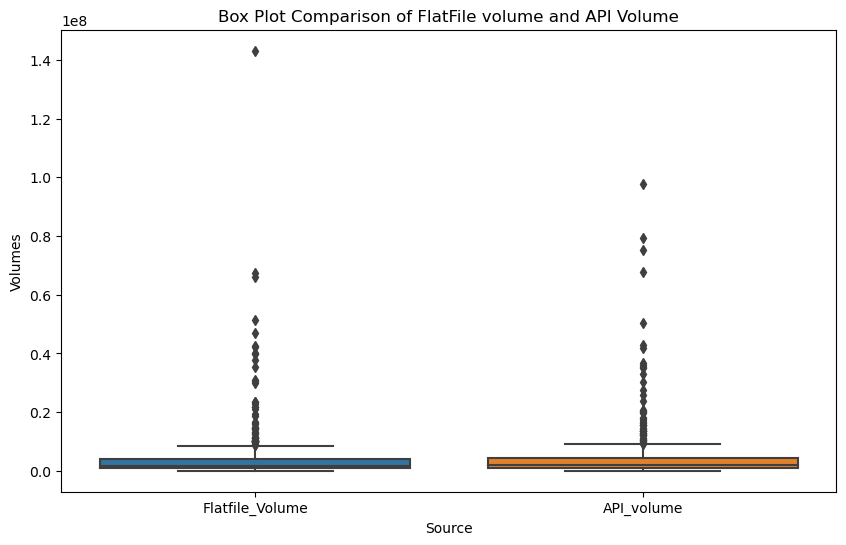

In [44]:

# Convert DataFrame to long format for seaborn, melt the DataFrame to long format using the melt method. 
# This format is required by seaborn for creating box plots with multiple columns.
df_melted = df_vol.melt(var_name='Column', value_name='Value')

# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Column', y='Value', data=df_melted)

# Add titles and labels
plt.title('Box Plot Comparison of FlatFile volume and API Volume')
plt.xlabel('Source')
plt.ylabel('Volumes')

# Show the plot
plt.show()

**Above box plot comparison shows volumes are almost simillar**

In [45]:
# Set display options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)  # None means show all columns

In [46]:
# print the Dataframe
df_combined

,Symbol,Name,Market_Cap,Price_Earnings_Ratio,EPS,Net_Income,Beta,Dividend,Div_Yield,Extended_Hr_Last_Price,Extended_Hr_Change_,Extended_Hr_%Change,Time,Last_Price,Change,%Chg,Opinion,20D_Relative_Strength,20D_His_Vol,20D_Avg_Vol,52W_Low,52W_High,Wtd_Alpha,YTD_%Chg,1M_%Chg,3M_%Chg,52W_%Chg,Sector,ISIN,Volume,WS_Symbol,Company_Name,GICS_Sector,GICS_Sub-Industry,Headquarters_Location,Date_added,Central_Index_Key,Year_Founded,API_Symbol,API_Volume,Vol_Wt_Avg_Price,Open_Price,Closing_Price,Highest_Price,Lowest_Price,Timestamp,Number_of_Transactions
0,A,Agilent Technologies,42235084000,26.32,5.37,1240000000,1.11,0.922,0.64%,144.1200,0.0000,0.00%,4/5/2024,144.1200,2.7800,1.97%,88% Buy,53.65%,17.81%,1711680,96.80,151.58,12.11,3.66%,-0.16%,10.39%,4.37%,Health Technology,US00846U1016,1.656M,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,0001090872,1999,A,1493858.0,153.7663,153.000,154.080,154.5500,152.5100,2024-05-15 16:00:00-04:00,31116.0
1,AAL,American Airlines Gp,9009457000,5.24,2.64,822000000,1.57,NaN,0.00%,13.7500,-0.0100,-0.07%,4/5/2024,13.7600,-0.0700,-0.51%,8% Sell,41.11%,37.04%,28192830,10.86,19.08,2.39,0.15%,-6.20%,1.18%,-0.94%,Transportation,US02376R1023,30.632M,AAL,American Airlines Group,Industrials,Passenger Airlines,"Fort Worth, Texas",2015-03-23,0000006201,1934,AAL,25741362.0,15.0357,15.200,14.940,15.2500,14.9101,2024-05-15 16:00:00-04:00,77768.0
2,AAPL,Apple Inc,2620000000000,26.30,6.42,96995000000,1.27,0.960,0.57%,169.4700,-0.1100,-0.06%,4/5/2024,169.5800,0.7600,0.45%,88% Sell,40.73%,21.24%,64083164,159.78,199.62,-3.00,-11.92%,-0.32%,-6.40%,3.55%,Electronic Technology,US0378331005,42.104M,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,0000320193,1977,AAPL,67561123.0,189.6510,187.910,189.720,190.6500,187.3700,2024-05-15 16:00:00-04:00,727552.0
3,ABBV,Abbvie Inc,301000000000,15.11,11.11,4863000000,0.58,5.990,3.52%,169.9900,-0.0100,-0.01%,4/5/2024,170.0000,2.1000,1.25%,56% Buy,41.80%,24.03%,6737740,130.96,182.89,10.74,9.70%,-5.11%,4.85%,5.72%,Health Technology,US00287Y1091,7.03M,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013,ABBV,5171030.0,163.4039,162.310,163.790,164.4200,161.8700,2024-05-15 16:00:00-04:00,77209.0
4,ABNB,Airbnb Inc Cl A,105000000000,36.85,4.31,4792000000,1.25,NaN,0.00%,161.7700,0.0000,0.00%,4/5/2024,161.7700,2.9300,1.84%,80% Buy,53.66%,22.45%,4004745,103.55,170.10,43.69,18.83%,1.53%,18.97%,40.25%,Consumer Services,US0090661010,2.226M,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,0001559720,2008,ABNB,5974665.0,145.8275,147.570,145.800,147.6900,144.7500,2024-05-15 16:00:00-04:00,75551.0
5,ABT,Abbott Laboratories,193000000000,24.80,4.44,5723000000,0.74,2.080,1.87%,111.4900,0.2900,0.26%,4/5/2024,111.2000,1.0900,0.99%,40% Buy,43.22%,18.29%,6818020,89.67,121.64,7.55,1.03%,-6.14%,0.36%,6.71%,Health Technology,US0028241000,5.591M,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,ABT,5245282.0,104.5276,104.100,104.590,104.8300,104.1000,2024-05-15 16:00:00-04:00,66094.0
6,ACGL,Arch Capital Grp Ltd,35601260000,10.78,8.45,4443000000,0.57,NaN,0.00%,94.2900,-0.6100,-0.64%,4/5/2024,94.9000,3.8100,4.18%,100% Buy,67.94%,20.33%,1920730,68.31,95.01,38.54,27.78%,8.59%,23.55%,38.36%,Finance,BMG0450A1053,2.591M,ACGL,Arch Capital Group,Financials,Property & Casualty Insurance,"Hamilton, Bermuda",2022-11-01,0000947484,1995,ACGL,1455035.0,97.8576,97.380,97.870,98.3900,97.3200,2024-05-15 16:00:00-04:00,30165.0
7,ACN,Accenture Plc,223000000000,27.68,11.94,6871560000,1.19,4.820,1.45%,333.0000,0.0000,0.00%,4/5/2024,333.0000,2.5300,0.77%,8% Buy,37.23%,38.31%,3169775,261.68,387.51,13.74,-5.10%,-11.64%,-1.08%,18.37%,Technology Services,IE00B4BNMY34,3.695M,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,000146737

### The following changes were made to the data ###
**Flat File data**

- The 4th, 12th and 18th column header were renamed, , Changed "P/E" to "Price Earnings", FChanged "%Chg (Ext)" to "Extended Hr %Change" and changed "20D Rel Str" to "20D Relative Strength"
- Changed float numbers to int64 to eliminate exponential notation in the 'Market Cap' column.
- Values in the 'Volume' column contained a special character '?" within the values. Adjustments were made to eliminate this special character.

**Web Scraped Data**

3 headers of the web content table was changed for better context and calrity.

- Changed 'Security' to 'Company Name'
- Changed 'CIK' to 'Central Index Key'
- Changed 'Founded' to 'Year Founded'

**API data**

9 headers of the web content recieved was changed for better context and clarity.

- Change header name 'T' as 'Symbol' in column 1
- Change 'v' as 'Volume' in column 2
- Change 'c' as 'Closing Price' in column 5
- Change 'h' as 'Highest Price' in column 6
- Change 'l' as 'Lowest Price' in column 7
- Change 't' as 'Timestamp' in column 8
- Change 'vw' as 'Vol Wt Avg Price' in column 3
- Change 'o' as 'Open Price' in column 4
- Change 'n' as 'Number of Transactions' in column 9


### Legal or regulatory guidelines ###
All three datasets are available in public and are bound to legal and regulatory compliance.  These data are obtained from stock exchanges and respective company websites. These information does not influence any financial impact as these are post transaction data and are available through many other sources.


### No risks created based on the transformations done? ###
Following transformations done are to convert the datatype or infer values within the exisitng values or cosmetic changes

**Flat File**
- Convert float number to int64 to remove expontential listing or displaying (no value changed)
- Replace special character, replace with a no character or null character (just removed a 


**Web Scraped Data**
- Remove rows that has no value (removed a row that had no data .  might be due to html structure and not a data)

**API data**
- Convert 'Volume' and "Number of Transactions" to intger values
- Fill the average price of misssing values in 'Vol Wt Avg Price' with average price of 'Open price and 'Closing Price'
- Convert 'Timestamp' field with milli second values to a timezone field with date and time

###  Assumptions in cleaning/transforming the data ###
No assumptions were made on the data and used as is.<br>
Filling the average value in API dataset using high and low price mean value assumed that number of transactions were same betweeen those high and low prices of stock for that day.  

### Data Source verification ###
Data were sources from public domain and like Flat file from S&P500 web site,  web page in Wikipedia and API data from a Polygon website.  Any contradicted data in Flat file from S&P 500 website or Wikipedia can or will be verified by respective stock company or by public people using those data and feedback provided to rectify the same  API data is a feed from stock exchanges and can be verified across other financial or stock websites,  to retain subscriptions API data will be free from any ccorrupted data or human biased data


### Source of Data ###
Flat file is sourced from S&P website - https://www.spglobal.com/en 
Web page is scraped from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks
and API data from https://polygon.io/


### Ethical Implication ###
As the data is used as it is and no stock buy or sell recommendations are predicted or suggested ,  there are no ethical implication

